# TRANS_017 - Sample 2 Preprocessing

## Overview
This notebook performs comprehensive preprocessing of CITE-seq data for Sample 2. CITE-seq combines single-cell RNA sequencing with surface protein quantification using antibody-derived tags (ADTs).

## Key considerations:
- **Xenograft data**: Human cells injected into mouse - we need to filter mouse contamination
- **Dual modality**: Process both RNA (GEX) and protein (ADT) data
- **Quality control**: Rigorous QC to ensure high-quality cells

## Workflow:
1. Load CellRanger outputs
2. Initial QC and exploration
3. Filter mouse contamination
4. Cell-level QC filtering
5. RNA data normalization and processing
6. ADT data normalization and processing
7. Dimensionality reduction and clustering
8. Save processed data

In [1]:
# Import required libraries
import scanpy as sc
import numpy as np
import skmisc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Set up plotting parameters
sc.settings.verbosity = 3
sc.settings.set_figure_params(dpi=100, facecolor='white', frameon=False)
sns.set_style('whitegrid')

print(f"Scanpy version: {sc.__version__}")

Scanpy version: 1.11.5


/srv/ext_home/asbarros/.conda/envs/py_scrnaseq/lib/python3.10/site-packages/louvain/__init__.py:54: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import get_distribution, DistributionNotFound


## 1. Define Paths and Parameters

Set up file paths for CellRanger output and define QC thresholds. Adjust these parameters based on your specific dataset characteristics.

In [2]:
# Define sample information
SAMPLE_NAME = "Sample_2"

# Define paths - ADJUST THESE TO YOUR DATA LOCATION
CELLRANGER_OUTPUT = Path("/srv/ext_home/asbarros/ifs/ADA/SHARED/projects/BSSantos/TRANS_017/data/01_cellranger_output/Sample_2/outs/")
OUTPUT_DIR = Path("/srv/ext_home/asbarros/ifs/ADA/SHARED/projects/BSSantos/TRANS_017/data/02a_preprocessing/")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# QC thresholds - these are starting points, adjust based on your data
QC_PARAMS = {
    'min_genes': 200,           # Minimum genes per cell
    'min_cells': 3,             # Minimum cells expressing a gene
    'max_genes': 6000,          # Maximum genes per cell (filter potential doublets)
    'max_counts': 30000,        # Maximum total counts per cell
    'max_mito_pct': 20,         # Maximum mitochondrial percentage
    'mouse_content_max': 5,     # Maximum % mouse genes (for xenograft filtering)
    'adt_min_counts': 100,      # Minimum ADT counts per cell
}

print(f"Processing sample: {SAMPLE_NAME}")
print(f"Output directory: {OUTPUT_DIR}")

Processing sample: Sample_2
Output directory: /srv/ext_home/asbarros/ifs/ADA/SHARED/projects/BSSantos/TRANS_017/data/02a_preprocessing


## 2. Load CellRanger Data

CellRanger outputs are in Market Exchange (MEX) format. For CITE-seq, we have:
- **Gene Expression (GEX)**: RNA counts
- **Antibody Capture (ADT)**: Protein surface marker counts

The filtered_feature_bc_matrix contains both modalities.

In [3]:
# Load the CellRanger output
# This contains both GEX and ADT data
adata = sc.read_10x_mtx(
    CELLRANGER_OUTPUT / "filtered_feature_bc_matrix",
    cache=True,gex_only=False
)

print(f"\nLoaded data shape: {adata.shape}")
print(f"Total features: {adata.n_vars}")
print(f"Total cells: {adata.n_obs}")

# Check feature types
print("\nFeature types:")
print(adata.var['feature_types'].value_counts())

... writing an h5ad cache file to speedup reading next time

Loaded data shape: (2661, 72321)
Total features: 72321
Total cells: 2661

Feature types:
feature_types
Gene Expression     72302
Antibody Capture       19
Name: count, dtype: int64


## 3. Separate GEX and ADT Data

We'll process RNA and protein data separately as they require different normalization strategies:
- **RNA**: Log-normalization, highly variable gene selection
- **Protein**: CLR normalization (centered log-ratio), more stable quantification

In [4]:
# Separate GEX and ADT data
adata_gex = adata[:, adata.var['feature_types'] == 'Gene Expression'].copy()
adata_adt = adata[:, adata.var['feature_types'] == 'Antibody Capture'].copy()

print(f"GEX data: {adata_gex.shape}")
print(f"ADT data: {adata_adt.shape}")

# Store sample name
adata_gex.obs['sample'] = SAMPLE_NAME
adata_adt.obs['sample'] = SAMPLE_NAME

GEX data: (2661, 72302)
ADT data: (2661, 19)


## 4. Calculate QC Metrics

### Why these metrics matter:
- **Mitochondrial genes**: High mito % indicates dying/stressed cells
- **Mouse genes**: For xenograft experiments, we want pure human cells
- **Total counts/genes**: Too low = low quality, too high = potential doublets
- **ADT counts**: Low ADT counts may indicate technical issues

In [5]:
# Calculate mitochondrial gene percentage
adata_gex.var['mt'] = adata_gex.var_names.str.startswith('MT-')
sc.pp.calculate_qc_metrics(
    adata_gex, 
    qc_vars=['mt'], 
    percent_top=None, 
    log1p=False, 
    inplace=True
)

# Calculate mouse contamination (genes starting with lowercase indicate mouse)
# In CellRanger multi outputs, mouse genes are typically lowercase
adata_gex.var['mouse'] = adata_gex.var_names.str.match(r'^[a-z]')
sc.pp.calculate_qc_metrics(
    adata_gex, 
    qc_vars=['mouse'], 
    percent_top=None, 
    log1p=False, 
    inplace=True
)

# Calculate ADT QC metrics
sc.pp.calculate_qc_metrics(
    adata_adt,
    percent_top=None,
    log1p=False,
    inplace=True
)

print("QC metrics calculated successfully")

QC metrics calculated successfully


## 5. Visualize QC Metrics (Before Filtering)

Let's examine the distribution of QC metrics to inform our filtering decisions.

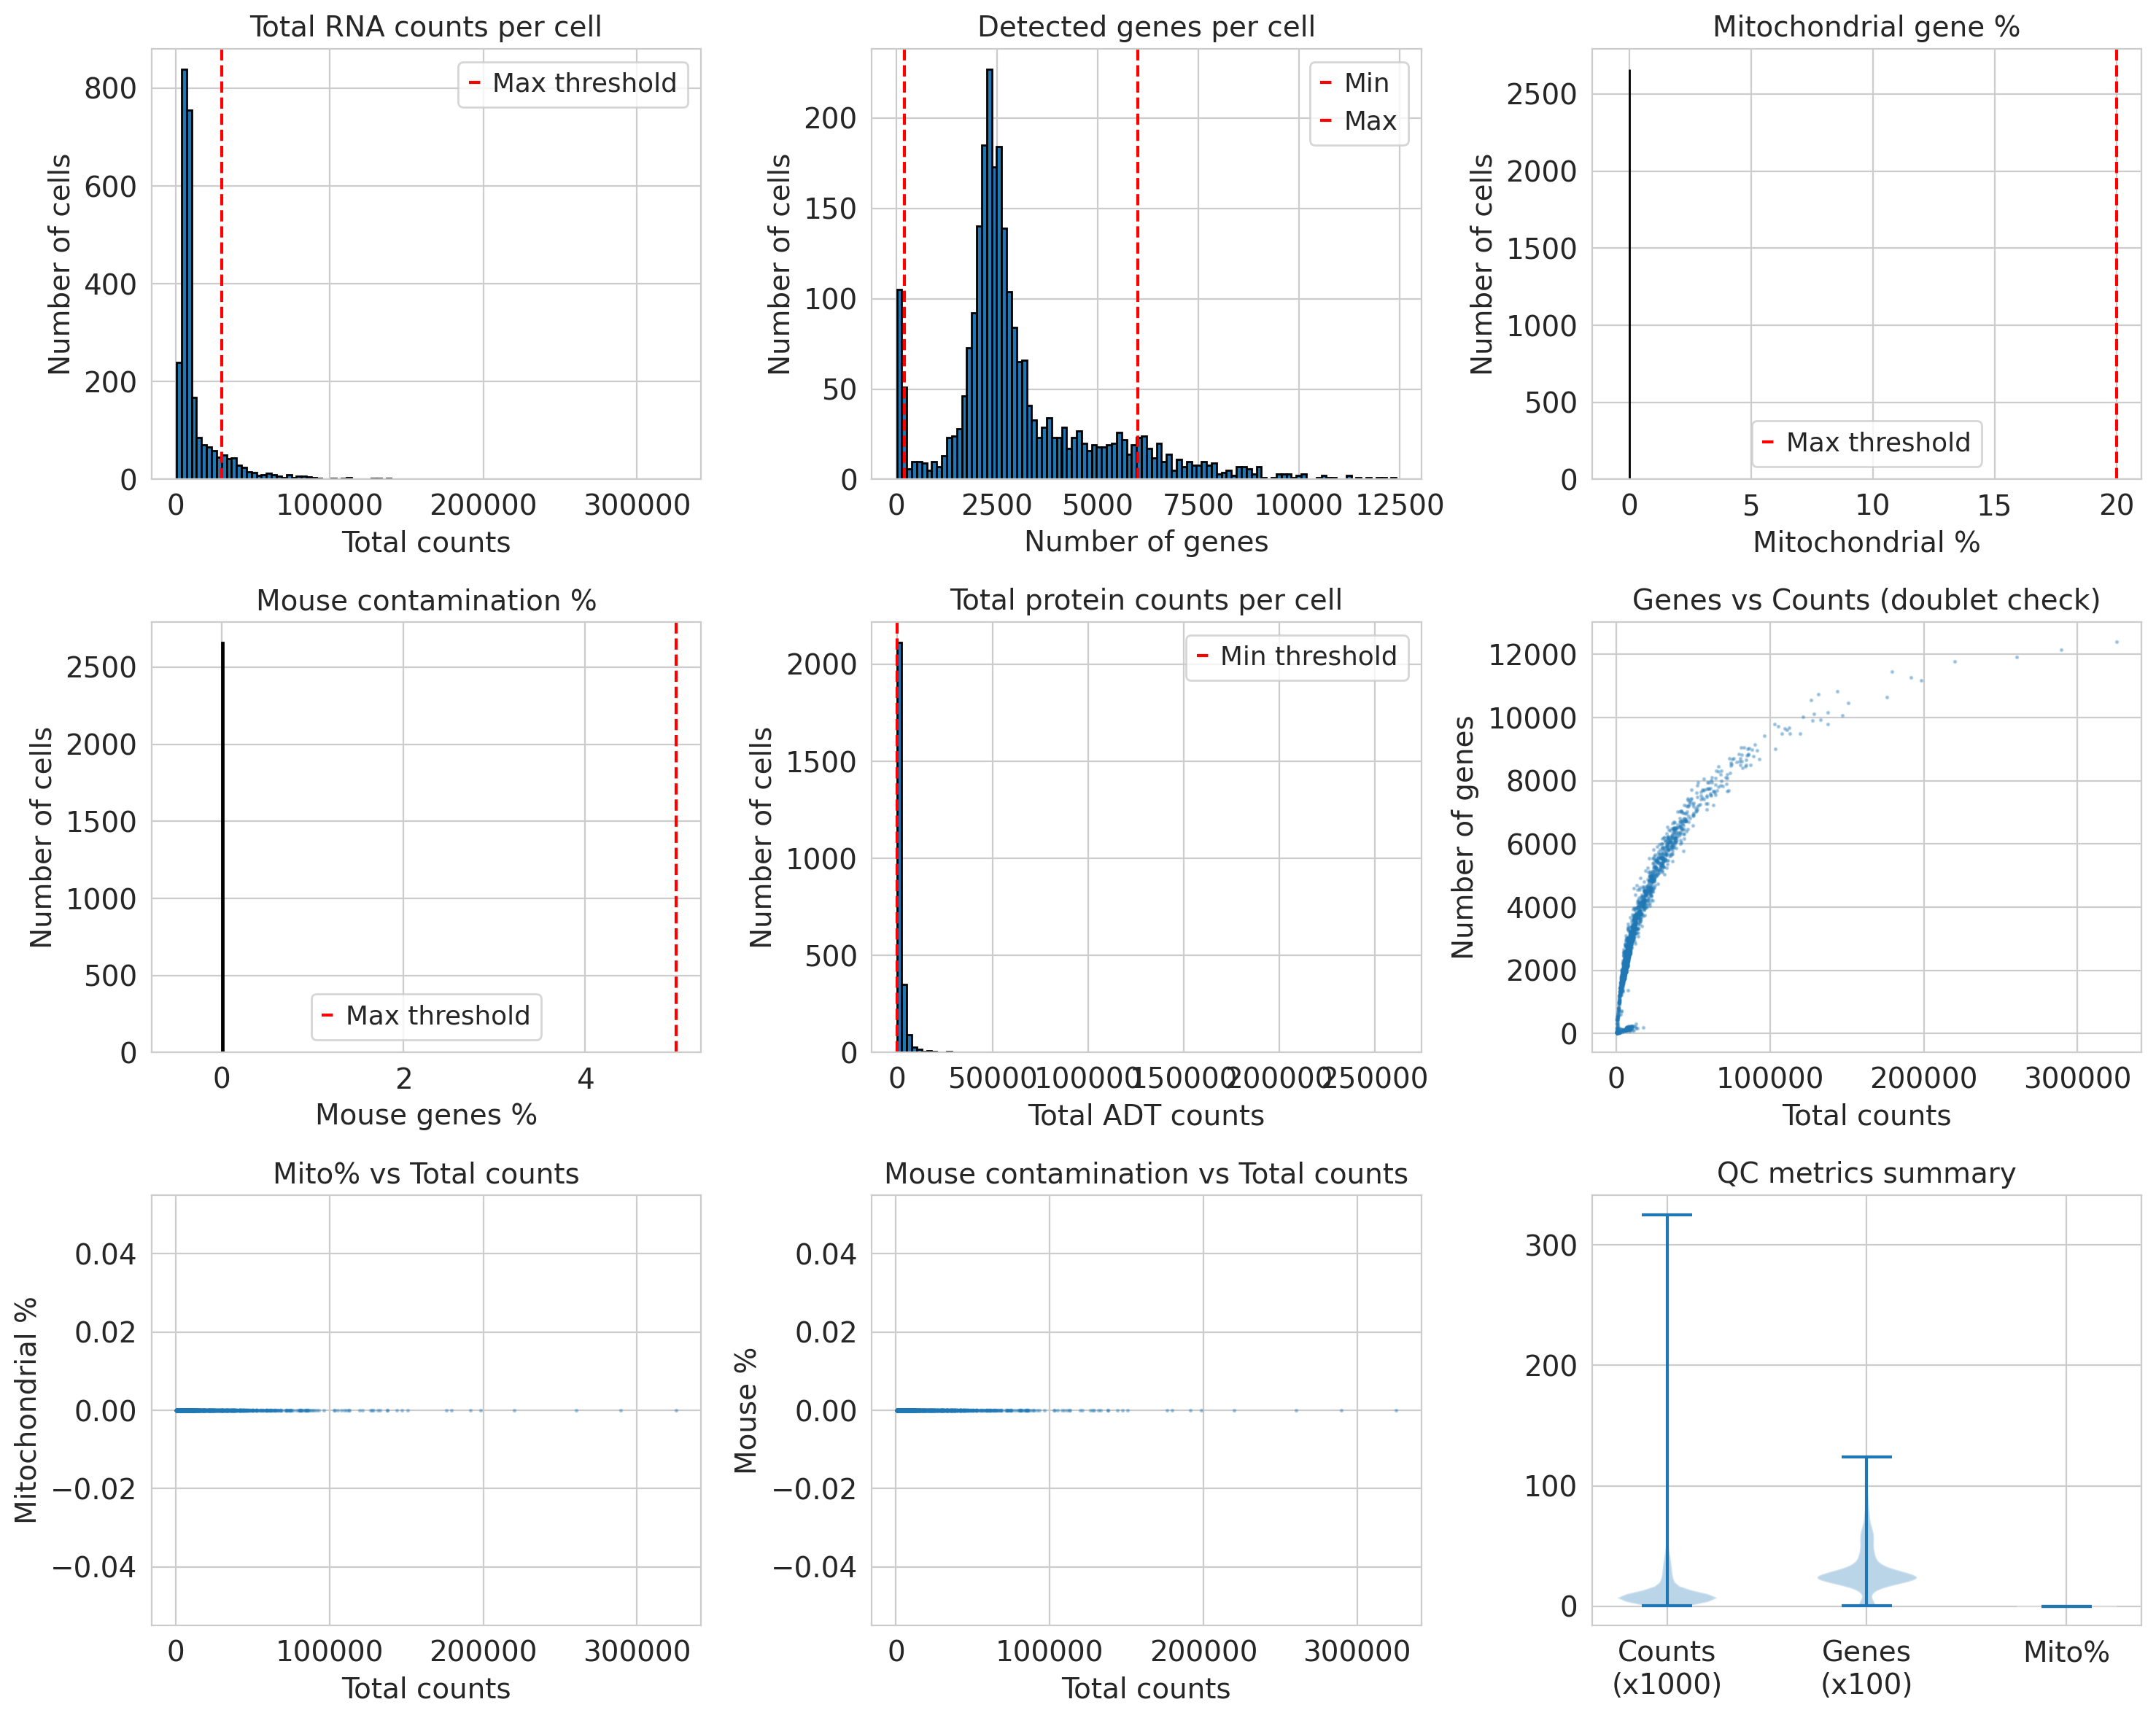


QC Summary (before filtering):
Total cells: 2661
Median genes/cell: 2560
Median counts/cell: 7729
Median mito%: 0.00
Median mouse%: 0.00
Median ADT counts: 1228


In [6]:
# Create comprehensive QC plots
fig, axes = plt.subplots(3, 3, figsize=(15, 12))

# Total counts distribution
axes[0, 0].hist(adata_gex.obs['total_counts'], bins=100, edgecolor='black')
axes[0, 0].set_xlabel('Total counts')
axes[0, 0].set_ylabel('Number of cells')
axes[0, 0].set_title('Total RNA counts per cell')
axes[0, 0].axvline(QC_PARAMS['max_counts'], color='red', linestyle='--', label='Max threshold')
axes[0, 0].legend()

# Number of genes
axes[0, 1].hist(adata_gex.obs['n_genes_by_counts'], bins=100, edgecolor='black')
axes[0, 1].set_xlabel('Number of genes')
axes[0, 1].set_ylabel('Number of cells')
axes[0, 1].set_title('Detected genes per cell')
axes[0, 1].axvline(QC_PARAMS['min_genes'], color='red', linestyle='--', label='Min')
axes[0, 1].axvline(QC_PARAMS['max_genes'], color='red', linestyle='--', label='Max')
axes[0, 1].legend()

# Mitochondrial percentage
axes[0, 2].hist(adata_gex.obs['pct_counts_mt'], bins=100, edgecolor='black')
axes[0, 2].set_xlabel('Mitochondrial %')
axes[0, 2].set_ylabel('Number of cells')
axes[0, 2].set_title('Mitochondrial gene %')
axes[0, 2].axvline(QC_PARAMS['max_mito_pct'], color='red', linestyle='--', label='Max threshold')
axes[0, 2].legend()

# Mouse contamination
axes[1, 0].hist(adata_gex.obs['pct_counts_mouse'], bins=100, edgecolor='black')
axes[1, 0].set_xlabel('Mouse genes %')
axes[1, 0].set_ylabel('Number of cells')
axes[1, 0].set_title('Mouse contamination %')
axes[1, 0].axvline(QC_PARAMS['mouse_content_max'], color='red', linestyle='--', label='Max threshold')
axes[1, 0].legend()

# ADT counts
axes[1, 1].hist(adata_adt.obs['total_counts'], bins=100, edgecolor='black')
axes[1, 1].set_xlabel('Total ADT counts')
axes[1, 1].set_ylabel('Number of cells')
axes[1, 1].set_title('Total protein counts per cell')
axes[1, 1].axvline(QC_PARAMS['adt_min_counts'], color='red', linestyle='--', label='Min threshold')
axes[1, 1].legend()

# Genes vs counts (doublet detection)
axes[1, 2].scatter(adata_gex.obs['total_counts'], adata_gex.obs['n_genes_by_counts'], 
                   alpha=0.3, s=1)
axes[1, 2].set_xlabel('Total counts')
axes[1, 2].set_ylabel('Number of genes')
axes[1, 2].set_title('Genes vs Counts (doublet check)')

# Mito % vs total counts
axes[2, 0].scatter(adata_gex.obs['total_counts'], adata_gex.obs['pct_counts_mt'], 
                   alpha=0.3, s=1)
axes[2, 0].set_xlabel('Total counts')
axes[2, 0].set_ylabel('Mitochondrial %')
axes[2, 0].set_title('Mito% vs Total counts')

# Mouse % vs total counts
axes[2, 1].scatter(adata_gex.obs['total_counts'], adata_gex.obs['pct_counts_mouse'], 
                   alpha=0.3, s=1)
axes[2, 1].set_xlabel('Total counts')
axes[2, 1].set_ylabel('Mouse %')
axes[2, 1].set_title('Mouse contamination vs Total counts')

# Violin plots summary
axes[2, 2].violinplot([adata_gex.obs['total_counts']/1000, 
                       adata_gex.obs['n_genes_by_counts']/100,
                       adata_gex.obs['pct_counts_mt']])
axes[2, 2].set_xticks([1, 2, 3])
axes[2, 2].set_xticklabels(['Counts\n(x1000)', 'Genes\n(x100)', 'Mito%'])
axes[2, 2].set_title('QC metrics summary')

plt.tight_layout()
plt.savefig(OUTPUT_DIR / f"{SAMPLE_NAME}_qc_before_filtering.png", dpi=300, bbox_inches='tight')
plt.show()

print("\nQC Summary (before filtering):")
print(f"Total cells: {adata_gex.n_obs}")
print(f"Median genes/cell: {adata_gex.obs['n_genes_by_counts'].median():.0f}")
print(f"Median counts/cell: {adata_gex.obs['total_counts'].median():.0f}")
print(f"Median mito%: {adata_gex.obs['pct_counts_mt'].median():.2f}")
print(f"Median mouse%: {adata_gex.obs['pct_counts_mouse'].median():.2f}")
print(f"Median ADT counts: {adata_adt.obs['total_counts'].median():.0f}")

## 6. Apply QC Filters

### Filtering strategy:
1. **Remove mouse contamination**: Keep only cells with <5% mouse genes (xenograft cleanup)
2. **Remove low-quality cells**: Min genes/counts thresholds
3. **Remove potential doublets**: Max genes/counts thresholds
4. **Remove dying cells**: Max mitochondrial percentage
5. **Filter genes**: Remove genes expressed in very few cells

In [7]:
print(f"Cells before filtering: {adata_gex.n_obs}")

# Store pre-filter data for comparison
n_cells_initial = adata_gex.n_obs

# Filter 1: Remove mouse contamination
adata_gex = adata_gex[adata_gex.obs['pct_counts_mouse'] < QC_PARAMS['mouse_content_max'], :]
print(f"After mouse filter: {adata_gex.n_obs} cells ({adata_gex.n_obs/n_cells_initial*100:.1f}%)")

# Filter 2: Gene counts per cell
adata_gex = adata_gex[adata_gex.obs['n_genes_by_counts'] >= QC_PARAMS['min_genes'], :]
adata_gex = adata_gex[adata_gex.obs['n_genes_by_counts'] <= QC_PARAMS['max_genes'], :]
print(f"After gene count filter: {adata_gex.n_obs} cells ({adata_gex.n_obs/n_cells_initial*100:.1f}%)")

# Filter 3: Total counts per cell
adata_gex = adata_gex[adata_gex.obs['total_counts'] <= QC_PARAMS['max_counts'], :]
print(f"After total count filter: {adata_gex.n_obs} cells ({adata_gex.n_obs/n_cells_initial*100:.1f}%)")

# Filter 4: Mitochondrial percentage
adata_gex = adata_gex[adata_gex.obs['pct_counts_mt'] < QC_PARAMS['max_mito_pct'], :]
print(f"After mito filter: {adata_gex.n_obs} cells ({adata_gex.n_obs/n_cells_initial*100:.1f}%)")

# Filter ADT data to match filtered cells
adata_adt = adata_adt[adata_gex.obs_names, :]

# Filter 5: ADT counts
adt_pass = adata_adt.obs['total_counts'] >= QC_PARAMS['adt_min_counts']
adata_gex = adata_gex[adt_pass, :]
adata_adt = adata_adt[adt_pass, :]
print(f"After ADT count filter: {adata_gex.n_obs} cells ({adata_gex.n_obs/n_cells_initial*100:.1f}%)")

# Filter genes: Remove genes expressed in fewer than min_cells
sc.pp.filter_genes(adata_gex, min_cells=QC_PARAMS['min_cells'])

# Remove mouse genes from the dataset
human_genes = ~adata_gex.var['mouse']
adata_gex = adata_gex[:, human_genes]

print(f"\nFinal filtered data:")
print(f"Cells: {adata_gex.n_obs} ({adata_gex.n_obs/n_cells_initial*100:.1f}% retained)")
print(f"Genes: {adata_gex.n_vars}")
print(f"ADT features: {adata_adt.n_vars}")

Cells before filtering: 2661
After mouse filter: 2661 cells (100.0%)
After gene count filter: 2257 cells (84.8%)
After total count filter: 2188 cells (82.2%)
After mito filter: 2188 cells (82.2%)
After ADT count filter: 2133 cells (80.2%)
filtered out 54355 genes that are detected in less than 3 cells

Final filtered data:
Cells: 2133 (80.2% retained)
Genes: 17947
ADT features: 19


## 7. Normalize and Process RNA Data

### RNA normalization strategy:
1. **Normalize counts**: Scale to 10,000 reads per cell (CPM-like)
2. **Log-transform**: log1p transformation for variance stabilization
3. **Identify highly variable genes**: Focus on informative genes
4. **Scale**: Z-score normalization for PCA
5. **PCA**: Dimensionality reduction
6. **Neighborhood graph**: For clustering and UMAP

In [8]:
# Store raw counts for later use
adata_gex.layers['counts'] = adata_gex.X.copy()

# Normalize total counts per cell
# Each cell gets the same total count, removing cell-size effects
sc.pp.normalize_total(adata_gex, target_sum=1e4)

# Logarithmize the data
# log1p(x) = log(x + 1) to handle zeros
sc.pp.log1p(adata_gex)

# Store normalized data
adata_gex.layers['log_normalized'] = adata_gex.X.copy()

print("RNA normalization completed")

normalizing counts per cell
    finished (0:00:00)
RNA normalization completed


## 8. Identify Highly Variable Genes

We select genes with high biological variability while excluding genes with high technical noise. These genes will drive our clustering and visualization.

extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)
Number of highly variable genes: 2000


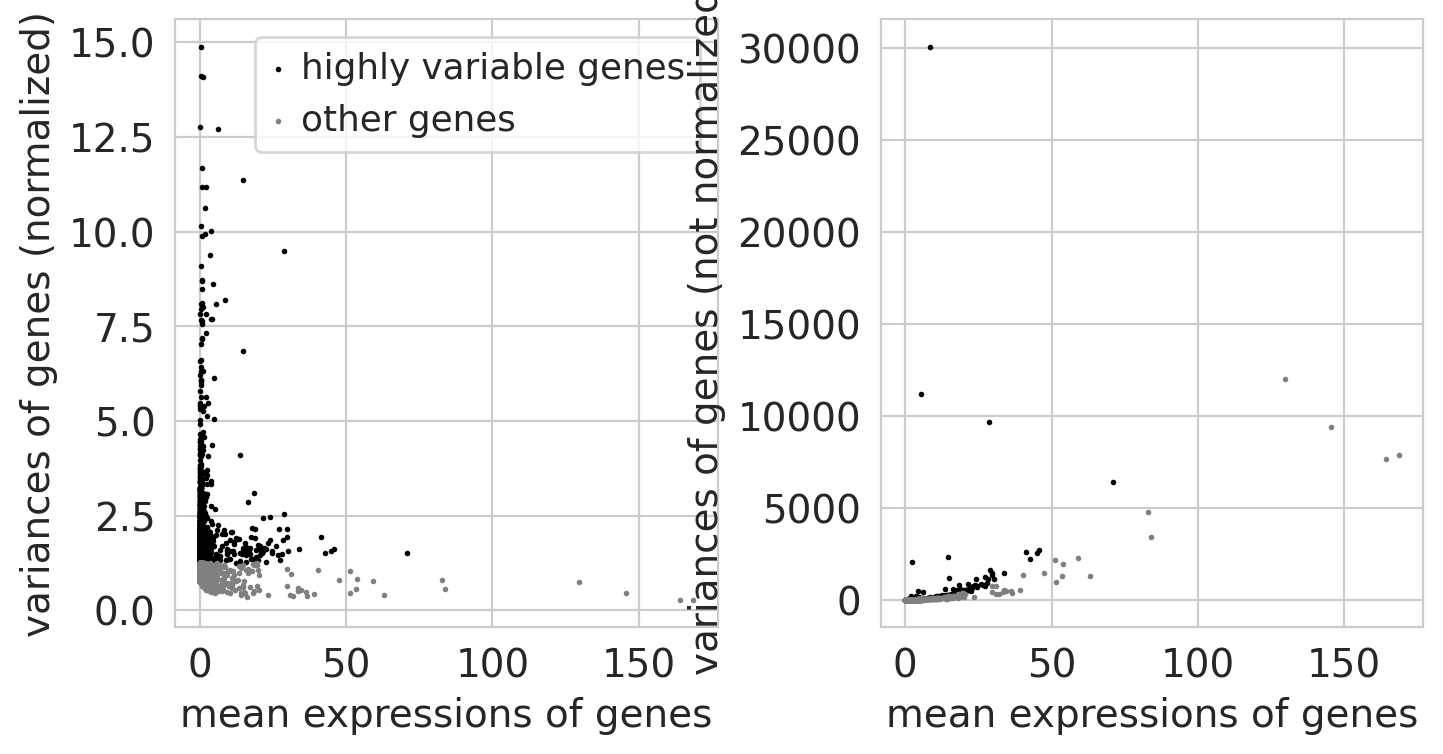

In [9]:
# Identify highly variable genes
sc.pp.highly_variable_genes(
    adata_gex,
    n_top_genes=2000,
    flavor='seurat_v3',
    layer='counts'
)

print(f"Number of highly variable genes: {adata_gex.var['highly_variable'].sum()}")

# Plot highly variable genes
sc.pl.highly_variable_genes(adata_gex, save=f'_{SAMPLE_NAME}_hvg.png')

## 9. Scale and Perform PCA

Scaling ensures all genes have equal weight in PCA, preventing highly expressed genes from dominating the analysis.

computing PCA
    with n_comps=50
    finished (0:00:00)


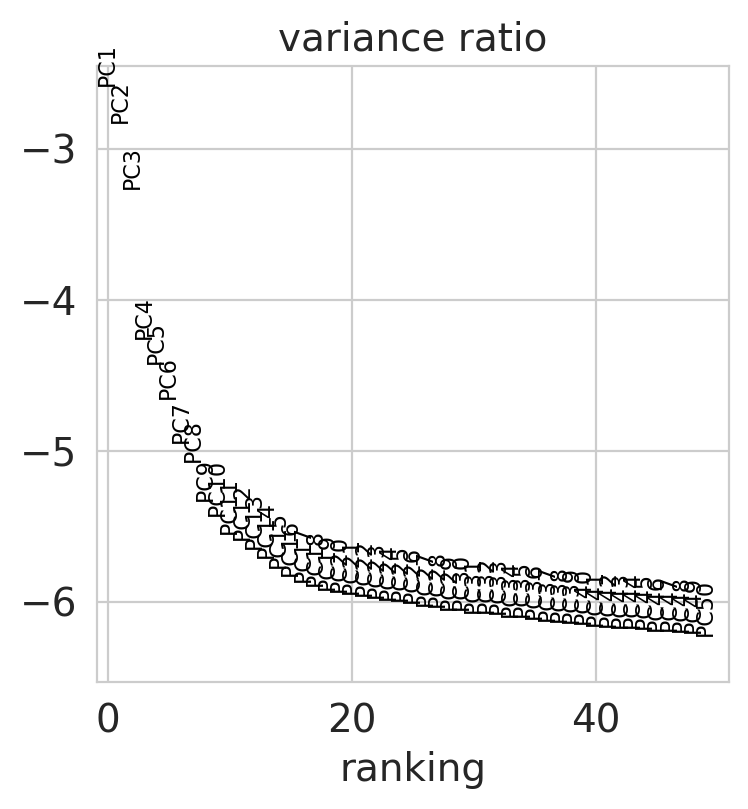

PCA completed


In [10]:
# Scale the data (Z-score normalization)
# Regressing out total_counts and pct_counts_mt can help, but may remove biology
# Start without regression, can add later if needed
sc.pp.scale(adata_gex, max_value=10)

# Perform PCA
# Using highly variable genes only
sc.tl.pca(adata_gex, svd_solver='arpack', n_comps=50)

# Plot PCA variance ratio to determine number of PCs to use
sc.pl.pca_variance_ratio(adata_gex, log=True, n_pcs=50, save=f'_{SAMPLE_NAME}_variance.png')

print("PCA completed")

## 10. Compute Neighborhood Graph and UMAP

The neighborhood graph connects similar cells, enabling clustering and low-dimensional visualization.

In [11]:
# Compute neighborhood graph
# n_neighbors: larger = more global structure, smaller = more local
# n_pcs: use elbow from variance plot, typically 30-50
sc.pp.neighbors(adata_gex, n_neighbors=15, n_pcs=30)

# Compute UMAP embedding
sc.tl.umap(adata_gex)

print("UMAP completed")

computing neighbors
    using 'X_pca' with n_pcs = 30
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:04)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:04)
UMAP completed


## 11. Clustering

Leiden clustering identifies cell populations. The resolution parameter controls granularity:
- Lower resolution (0.4-0.8): Broader cell types
- Higher resolution (1.0-2.0): More refined subtypes

running Leiden clustering
    finished: found 7 clusters and added
    'leiden_r0.4', the cluster labels (adata.obs, categorical) (0:00:00)
Resolution 0.4: 7 clusters
running Leiden clustering
    finished: found 7 clusters and added
    'leiden_r0.6', the cluster labels (adata.obs, categorical) (0:00:00)
Resolution 0.6: 7 clusters
running Leiden clustering
    finished: found 9 clusters and added
    'leiden_r0.8', the cluster labels (adata.obs, categorical) (0:00:00)
Resolution 0.8: 9 clusters
running Leiden clustering
    finished: found 11 clusters and added
    'leiden_r1.0', the cluster labels (adata.obs, categorical) (0:00:00)
Resolution 1.0: 11 clusters


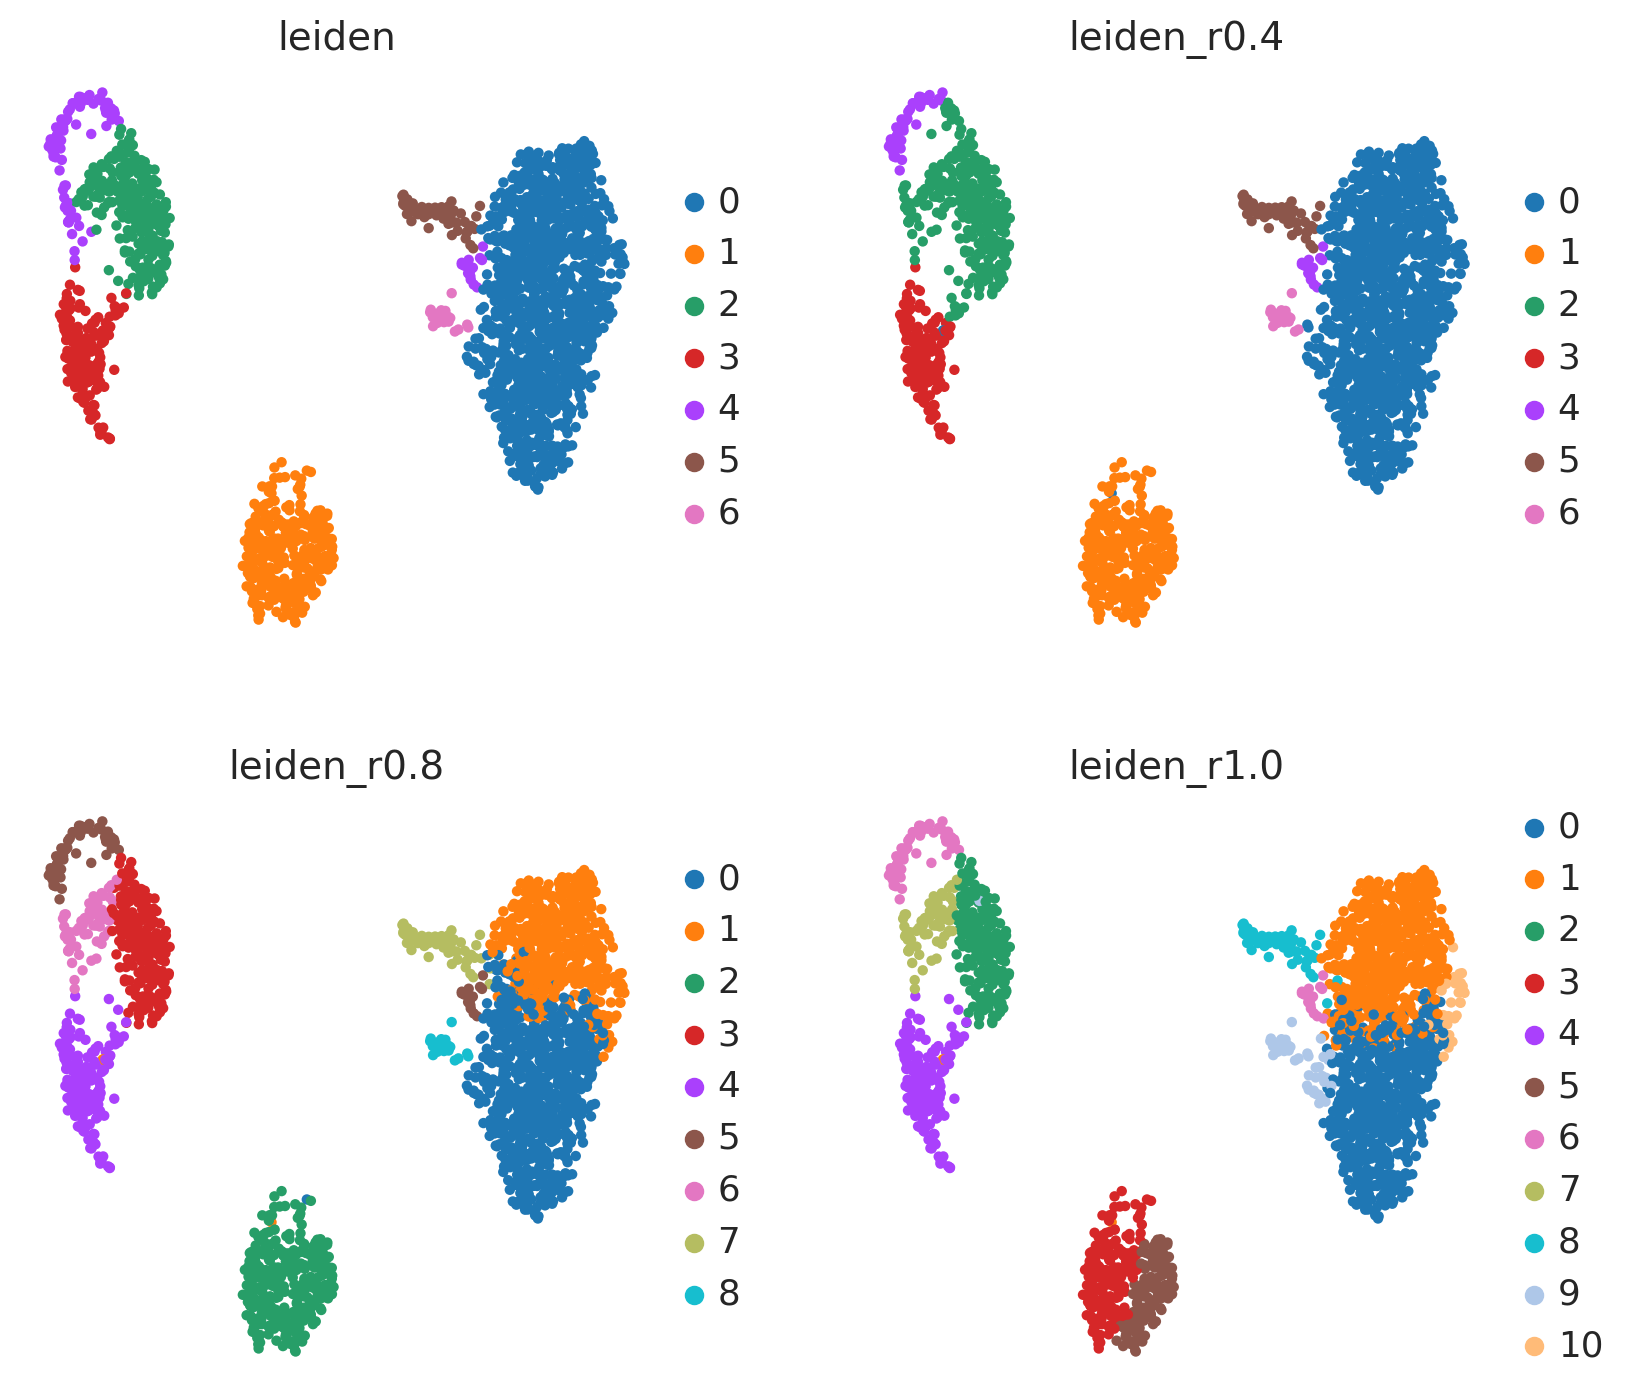

In [12]:
# Perform Leiden clustering at multiple resolutions
resolutions = [0.4, 0.6, 0.8, 1.0]

for res in resolutions:
    sc.tl.leiden(adata_gex, resolution=res, key_added=f'leiden_r{res}')
    print(f"Resolution {res}: {len(adata_gex.obs[f'leiden_r{res}'].unique())} clusters")

# Set default clustering
adata_gex.obs['leiden'] = adata_gex.obs['leiden_r0.6']

# Visualize clustering
sc.pl.umap(adata_gex, color=['leiden', 'leiden_r0.4', 'leiden_r0.8', 'leiden_r1.0'],
           ncols=2, save=f'_{SAMPLE_NAME}_clustering.png')

## 12. Visualize QC Metrics on UMAP

Check if technical factors correlate with clusters (batch effects).

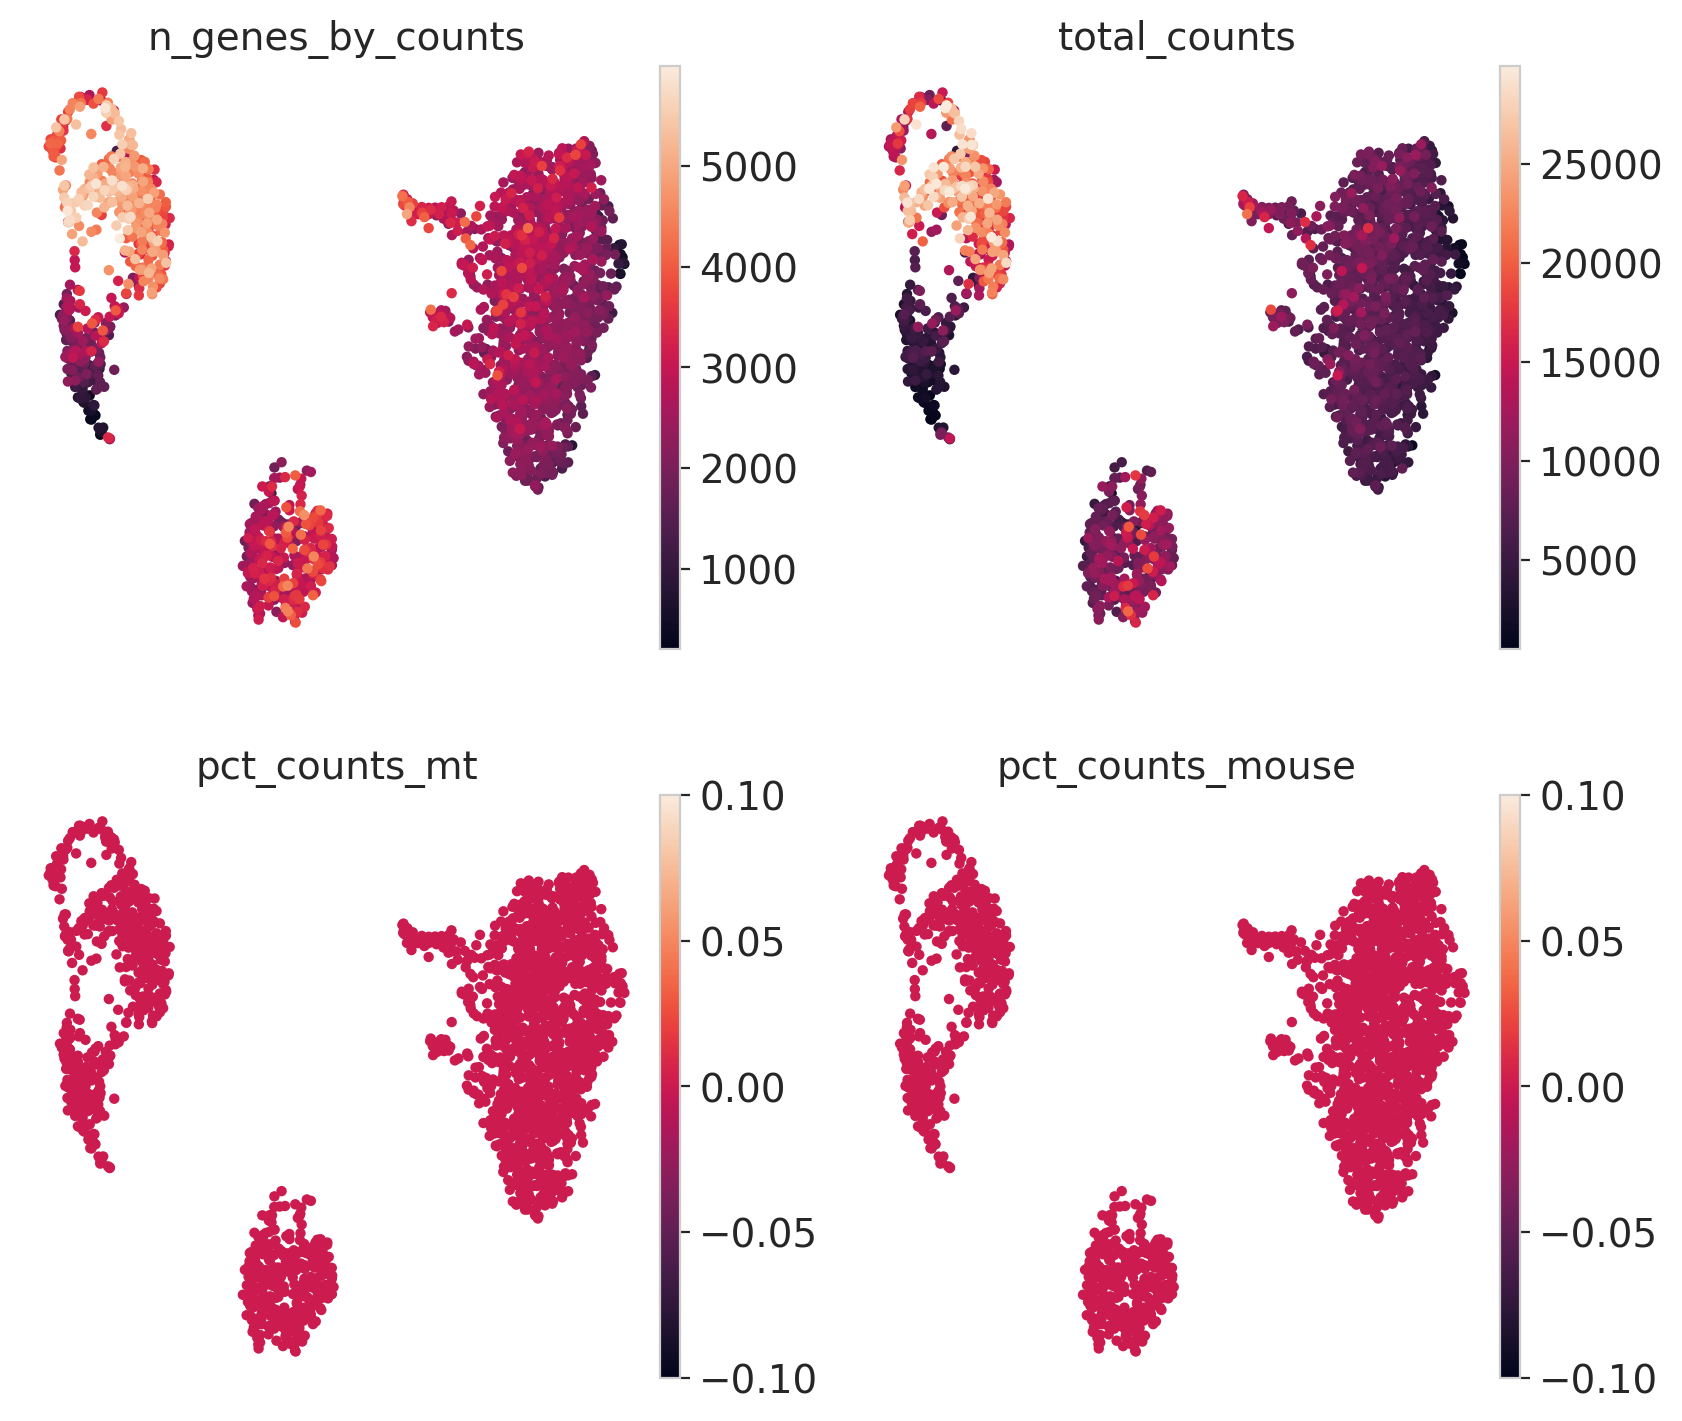

In [13]:
# Plot QC metrics on UMAP
sc.pl.umap(adata_gex, 
           color=['n_genes_by_counts', 'total_counts', 'pct_counts_mt', 'pct_counts_mouse'],
           ncols=2,
           save=f'_{SAMPLE_NAME}_qc_umap.png')

## 13. Process ADT (Protein) Data

### ADT normalization strategy:
Protein data has different characteristics than RNA:
- Less sparse (most proteins detected in most cells)
- Lower dynamic range
- Different technical noise structure

We use **CLR (Centered Log Ratio)** normalization:
1. More robust to outliers than standard normalization
2. Accounts for compositional nature of data
3. Better preserves protein-protein relationships

In [14]:
# Store raw ADT counts
adata_adt.layers['counts'] = adata_adt.X.copy()

# CLR normalization for ADT data
# This is the recommended approach for CITE-seq protein data
def clr_normalize(adata):
    """
    Centered Log Ratio (CLR) normalization.
    For each cell: log(count / geometric_mean_of_counts)
    """
    from scipy.stats import gmean
    import scipy.sparse as sp
    
    # Convert to dense if sparse
    if sp.issparse(adata.X):
        X = adata.X.toarray()
    else:
        X = adata.X.copy()
    
    # Add pseudocount
    X = X + 1
    
    # Calculate geometric mean for each cell
    geo_means = gmean(X, axis=1)
    
    # CLR transformation
    X_clr = np.log(X / geo_means[:, np.newaxis])
    
    return X_clr

# Apply CLR normalization
adata_adt.X = clr_normalize(adata_adt)
adata_adt.layers['clr_normalized'] = adata_adt.X.copy()

print("ADT CLR normalization completed")
print(f"ADT shape: {adata_adt.shape}")

ADT CLR normalization completed
ADT shape: (2133, 19)


## 14. Dimensionality Reduction on ADT Data

While RNA needs strong dimensionality reduction (thousands of genes → PCs), protein data is already low-dimensional (~50-200 proteins). We still compute PCA for consistency and to remove noise.

In [15]:
# Scale ADT data
sc.pp.scale(adata_adt)

# PCA on protein data
# Use fewer components since we have fewer features
n_comps = min(20, adata_adt.n_vars - 1)
sc.tl.pca(adata_adt, n_comps=n_comps)

# Compute neighborhood graph
sc.pp.neighbors(adata_adt, n_neighbors=15, n_pcs=min(10, n_comps))

# Compute UMAP
sc.tl.umap(adata_adt)

print("ADT dimensionality reduction completed")

computing PCA
    with n_comps=18
    finished (0:00:00)
computing neighbors
    using data matrix X directly
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:02)
ADT dimensionality reduction completed


## 15. Transfer Clustering from RNA to ADT

We'll use the RNA-based clustering as our primary cell type assignments and visualize them on the protein UMAP.

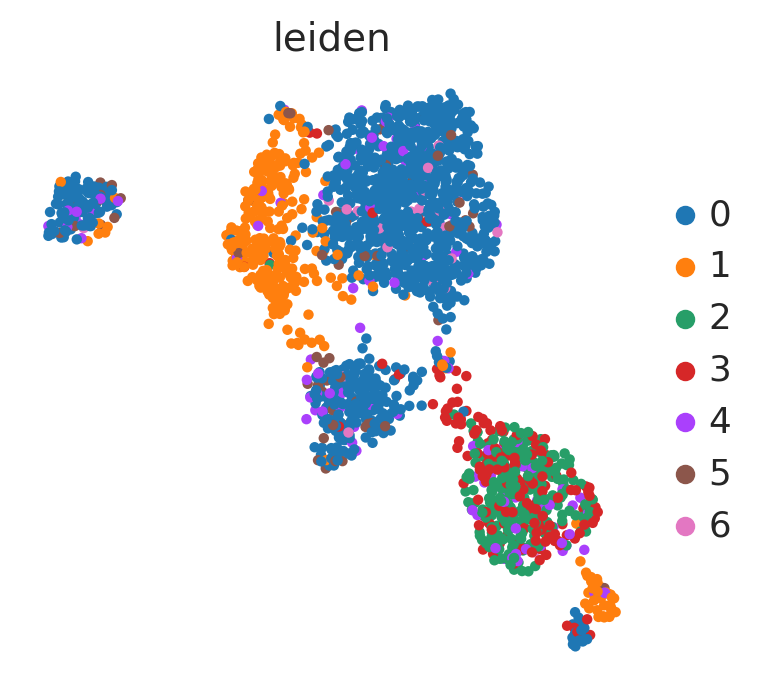

Clustering transferred to ADT data


In [16]:
# Transfer clustering and metadata from GEX to ADT
adata_adt.obs = adata_gex.obs.copy()

# Visualize RNA clusters on protein UMAP
sc.pl.umap(adata_adt, color='leiden', save=f'_{SAMPLE_NAME}_adt_leiden.png')

print("Clustering transferred to ADT data")

## 16. Visualize Key Proteins

Plot surface marker expression to help identify cell types.

Available proteins:
['Hu.CD103', 'Hu.CD183', 'Hu.CD25', 'Hu.CD27', 'Hu.CD279', 'Hu.CD38_HIT2', 'Hu.CD45RA', 'Hu.CD45RO', 'Hu.CD62L', 'Hu.CD69', 'Hu.Hashtag_1', 'Hu.Hashtag_2', 'Hu.Hashtag_3', 'Hu.Hashtag_4', 'Hu.Hashtag_5', 'Hu.Hashtag_6', 'Hu.Hashtag_7', 'Hu.Hashtag_8', 'Hu.Hashtag_9']


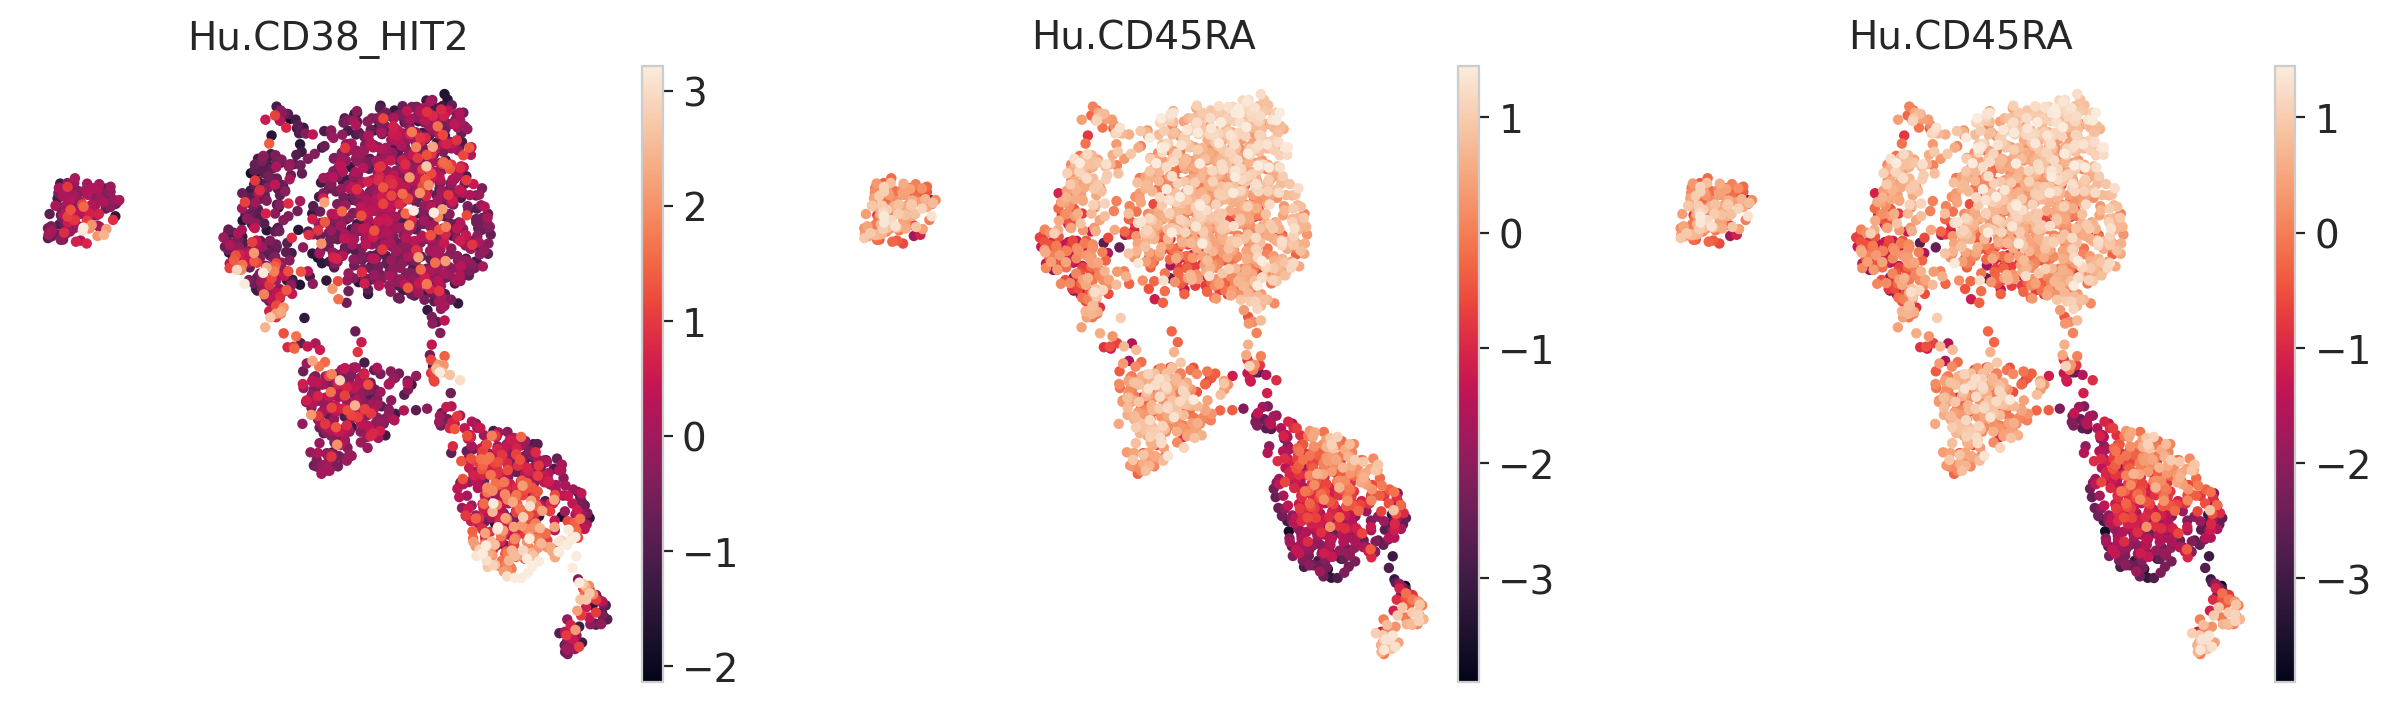

In [17]:
# Show all available proteins
print("Available proteins:")
print(adata_adt.var_names.tolist())

# If you have common markers, visualize them
# Adjust this list based on your antibody panel
common_markers = ['CD3', 'CD4', 'CD8', 'CD19', 'CD14', 'CD56', 'CD45']
available_markers = [m for m in common_markers if any(m in name for name in adata_adt.var_names)]

if len(available_markers) > 0:
    # Find exact marker names
    marker_names = []
    for marker in available_markers:
        matching = [name for name in adata_adt.var_names if marker in name]
        if matching:
            marker_names.append(matching[0])
    
    if marker_names:
        sc.pl.umap(adata_adt, color=marker_names, ncols=3, 
                   vmax='p99', save=f'_{SAMPLE_NAME}_key_proteins.png')
else:
    print("No common markers found, showing first 6 proteins:")
    sc.pl.umap(adata_adt, color=adata_adt.var_names[:6].tolist(), ncols=3,
               vmax='p99', save=f'_{SAMPLE_NAME}_proteins.png')

## 17. Combine GEX and ADT into Single Object

Store protein data as a layer in the main GEX object for integrated analysis.

In [18]:
# Add ADT data to main adata object
# Store normalized ADT data in obsm (observations matrix)
adata_gex.obsm['protein_counts'] = adata_adt.layers['counts']
adata_gex.obsm['protein_clr'] = adata_adt.layers['clr_normalized']

# Store ADT PCA and UMAP
adata_gex.obsm['X_pca_protein'] = adata_adt.obsm['X_pca']
adata_gex.obsm['X_umap_protein'] = adata_adt.obsm['X_umap']

# Store protein names
adata_gex.uns['protein_names'] = adata_adt.var_names.tolist()

print("GEX and ADT data combined")
print(f"Final object shape: {adata_gex.shape}")
print(f"Protein features: {len(adata_gex.uns['protein_names'])}")

GEX and ADT data combined
Final object shape: (2133, 17947)
Protein features: 19


## 18. Generate Summary Statistics

Create a comprehensive summary of the processed dataset.

In [19]:
# Summary statistics
summary = {
    'sample': SAMPLE_NAME,
    'n_cells_raw': n_cells_initial,
    'n_cells_filtered': adata_gex.n_obs,
    'retention_rate': f"{adata_gex.n_obs/n_cells_initial*100:.1f}%",
    'n_genes': adata_gex.n_vars,
    'n_proteins': len(adata_gex.uns['protein_names']),
    'n_clusters_default': len(adata_gex.obs['leiden'].unique()),
    'median_genes_per_cell': adata_gex.obs['n_genes_by_counts'].median(),
    'median_counts_per_cell': adata_gex.obs['total_counts'].median(),
    'median_mito_pct': adata_gex.obs['pct_counts_mt'].median(),
}

# Print summary
print("\n" + "="*50)
print(f"PROCESSING SUMMARY - {SAMPLE_NAME}")
print("="*50)
for key, value in summary.items():
    print(f"{key:30s}: {value}")
print("="*50 + "\n")

# Save summary to file
pd.DataFrame([summary]).to_csv(OUTPUT_DIR / f"{SAMPLE_NAME}_summary.csv", index=False)


PROCESSING SUMMARY - Sample_2
sample                        : Sample_2
n_cells_raw                   : 2661
n_cells_filtered              : 2133
retention_rate                : 80.2%
n_genes                       : 17947
n_proteins                    : 19
n_clusters_default            : 7
median_genes_per_cell         : 2508.0
median_counts_per_cell        : 7362.0
median_mito_pct               : 0.0



## 19. Save Processed Data

Save the processed AnnData object for downstream integration analysis.

In [20]:
# Save processed data
output_file = OUTPUT_DIR / f"{SAMPLE_NAME}_processed.h5ad"
adata_gex.write(output_file)

print(f"\nProcessed data saved to: {output_file}")
print(f"File size: {output_file.stat().st_size / 1024**2:.1f} MB")

OSError: [Errno 95] Unable to extend file properly, errno = 95, error message = 'operation not supported' (file write failed: time = Mon Jan 19 22:59:27 2026
, filename = '/srv/ext_home/asbarros/ifs/ADA/SHARED/projects/BSSantos/TRANS_017/data/02a_preprocessing/Sample_2_processed.h5ad', file descriptor = 75, errno = 95, error message = 'Operation not supported', buf = 0x5625fd56db30, total write size = 1736, bytes this sub-write = 1736, offset = 96)

## 20. Final Visualizations

Create publication-quality plots summarizing the analysis.

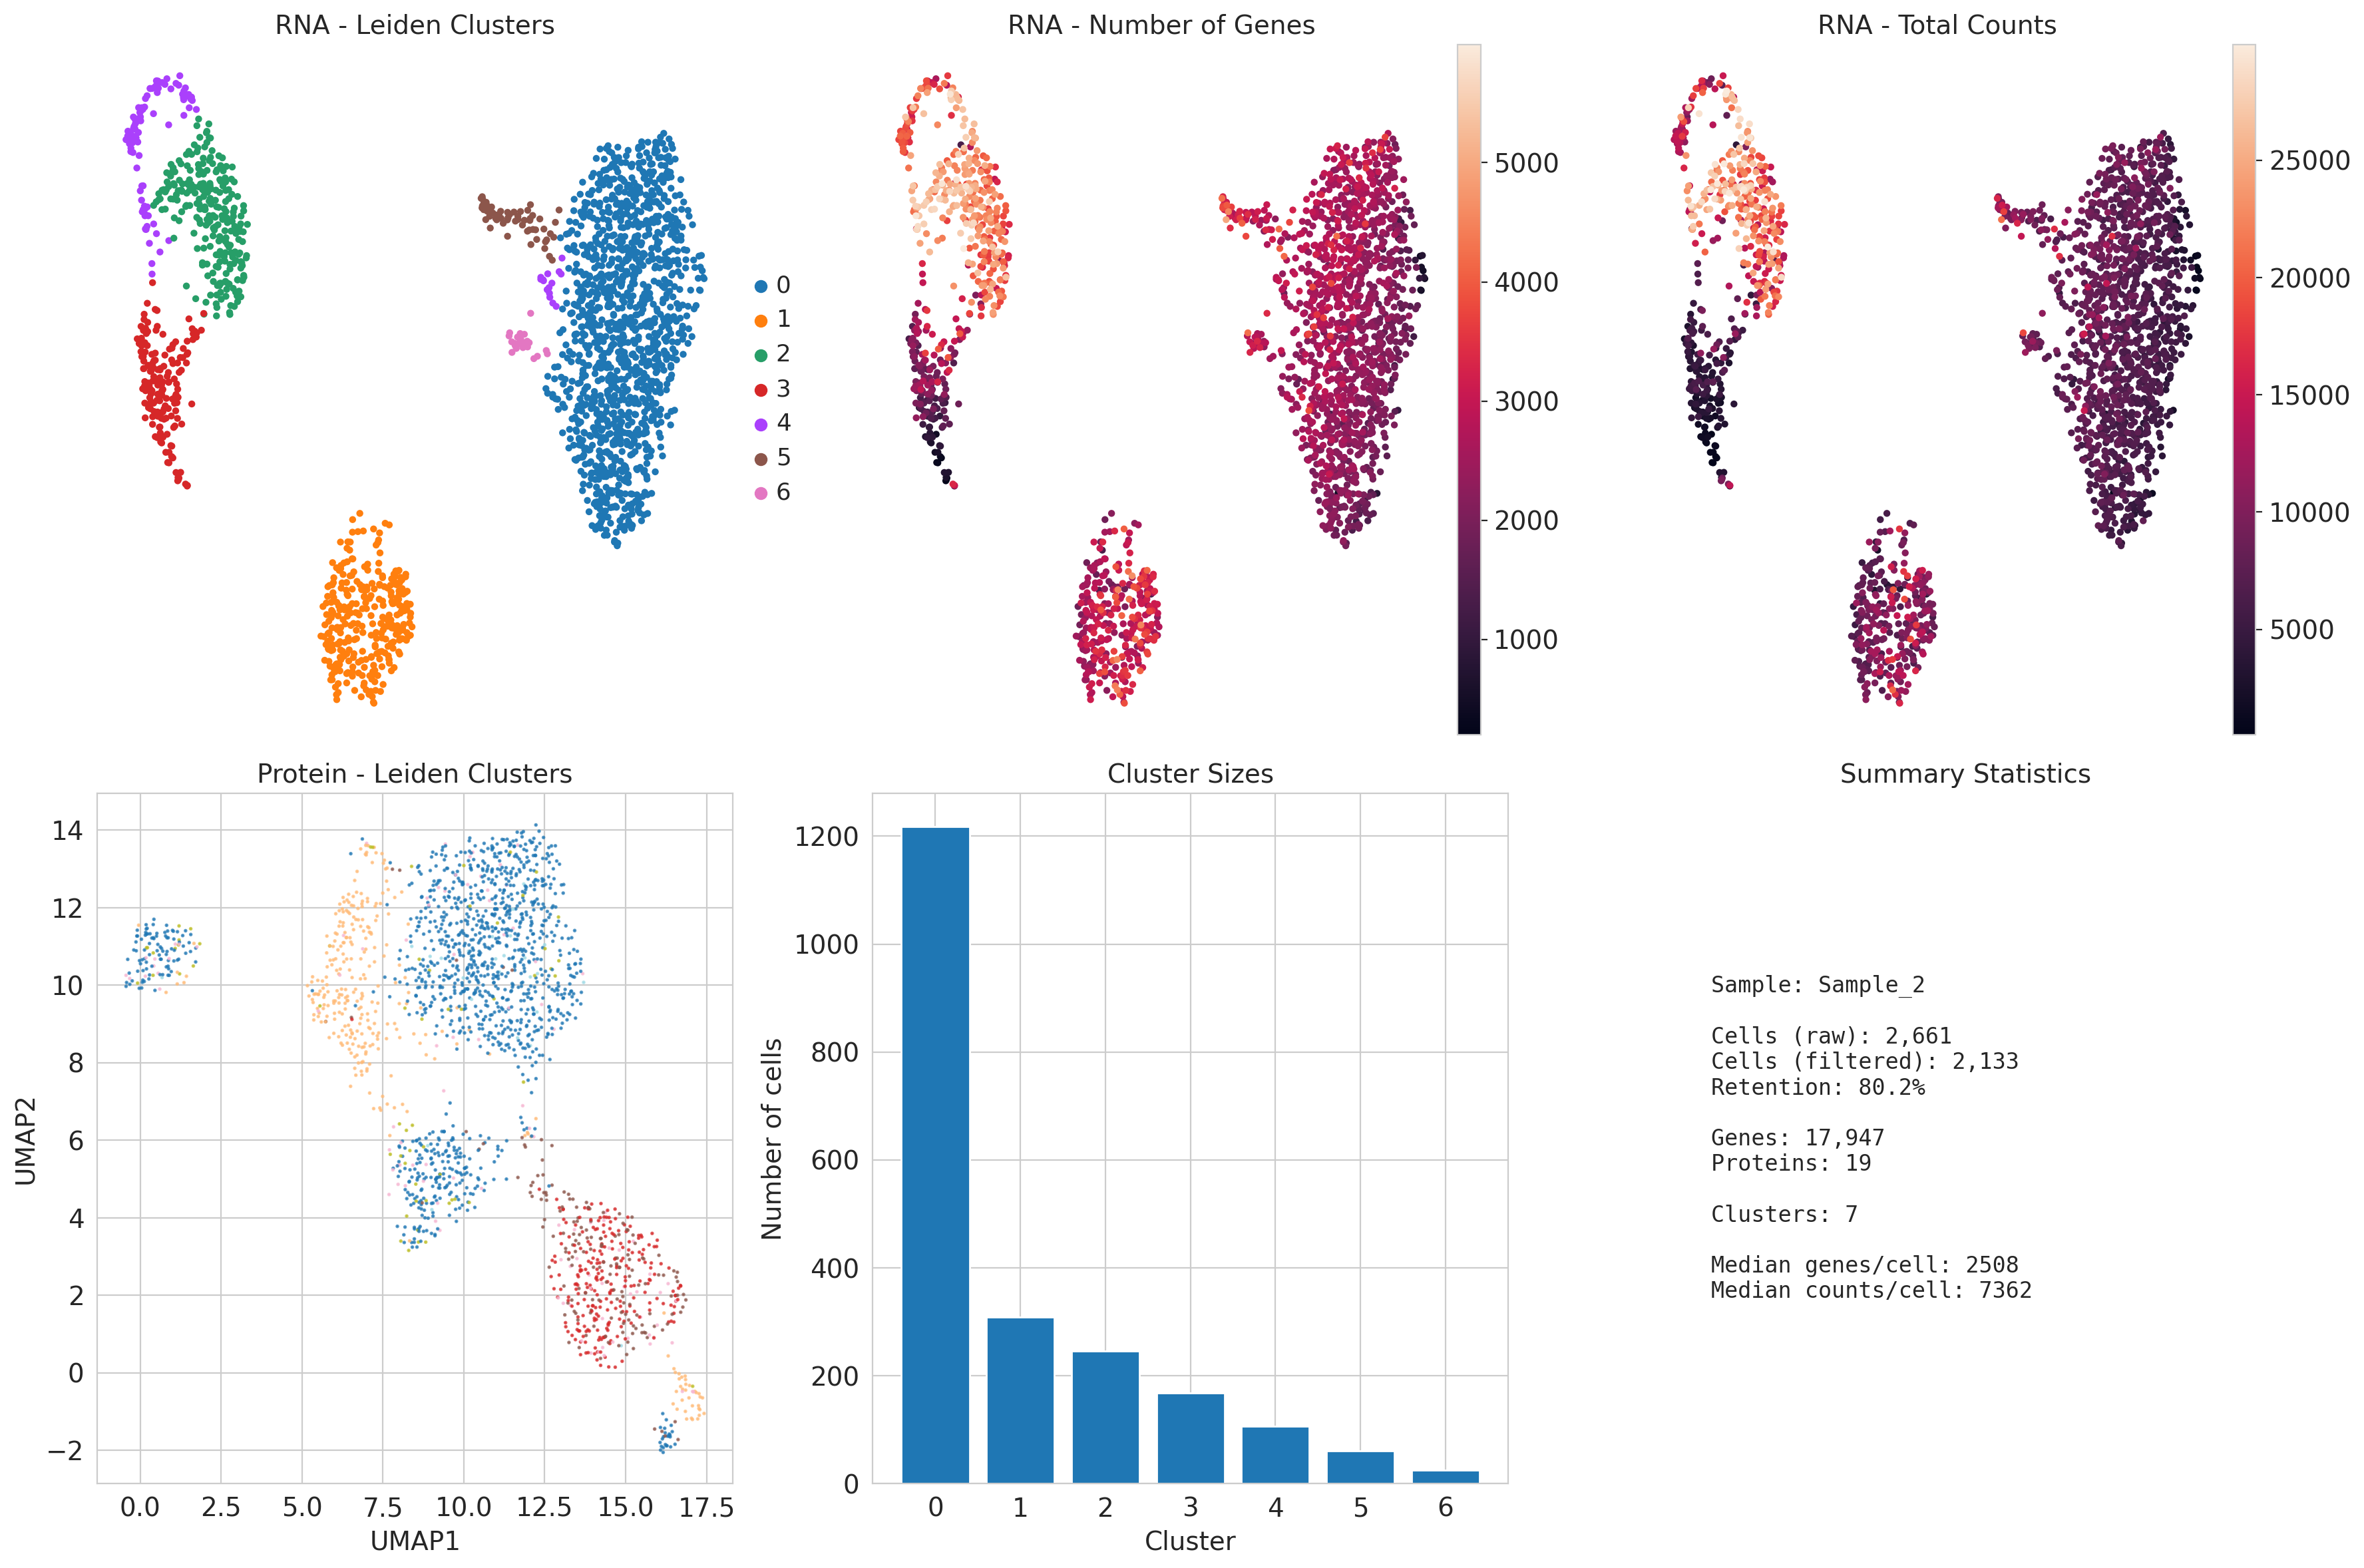


✓ Processing complete for Sample_2!

Output files saved to: /srv/ext_home/asbarros/ifs/ADA/SHARED/projects/BSSantos/TRANS_017/data/02a_preprocessing


In [21]:
# Create comprehensive summary figure
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# RNA UMAP colored by clusters
sc.pl.umap(adata_gex, color='leiden', ax=axes[0, 0], show=False, title='RNA - Leiden Clusters')

# RNA UMAP colored by genes
sc.pl.umap(adata_gex, color='n_genes_by_counts', ax=axes[0, 1], show=False, 
           title='RNA - Number of Genes')

# RNA UMAP colored by counts
sc.pl.umap(adata_gex, color='total_counts', ax=axes[0, 2], show=False,
           title='RNA - Total Counts')

# Protein UMAP colored by clusters
axes[1, 0].scatter(adata_gex.obsm['X_umap_protein'][:, 0],
                   adata_gex.obsm['X_umap_protein'][:, 1],
                   c=adata_gex.obs['leiden'].astype(int),
                   cmap='tab20',
                   s=1,
                   alpha=0.7)
axes[1, 0].set_title('Protein - Leiden Clusters')
axes[1, 0].set_xlabel('UMAP1')
axes[1, 0].set_ylabel('UMAP2')

# Cluster sizes
cluster_sizes = adata_gex.obs['leiden'].value_counts().sort_index()
axes[1, 1].bar(range(len(cluster_sizes)), cluster_sizes.values)
axes[1, 1].set_xlabel('Cluster')
axes[1, 1].set_ylabel('Number of cells')
axes[1, 1].set_title('Cluster Sizes')
axes[1, 1].set_xticks(range(len(cluster_sizes)))
axes[1, 1].set_xticklabels(cluster_sizes.index)

# QC summary
axes[1, 2].axis('off')
summary_text = f"""
Sample: {SAMPLE_NAME}

Cells (raw): {n_cells_initial:,}
Cells (filtered): {adata_gex.n_obs:,}
Retention: {adata_gex.n_obs/n_cells_initial*100:.1f}%

Genes: {adata_gex.n_vars:,}
Proteins: {len(adata_gex.uns['protein_names'])}

Clusters: {len(adata_gex.obs['leiden'].unique())}

Median genes/cell: {adata_gex.obs['n_genes_by_counts'].median():.0f}
Median counts/cell: {adata_gex.obs['total_counts'].median():.0f}
"""
axes[1, 2].text(0.1, 0.5, summary_text, fontsize=12, family='monospace',
                verticalalignment='center')
axes[1, 2].set_title('Summary Statistics')

plt.tight_layout()
plt.savefig(OUTPUT_DIR / f"{SAMPLE_NAME}_summary_figure.png", dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✓ Processing complete for {SAMPLE_NAME}!")
print(f"\nOutput files saved to: {OUTPUT_DIR}")

## Next Steps

1. **Repeat for all samples**: Run this notebook for samples 2, 3, and 4
2. **Cell type annotation**: Use marker genes to identify cell types in each cluster
3. **Integration**: Move to the integration notebook to combine all samples

### Notes for integration:
- All samples are now standardized and ready for batch correction
- scVI-tools will be used for integration, which handles both modalities
- Save all processed samples before proceeding to integration